Train rows: 13756  Val rows: 3458
Train positives: 2524  /  13756
Validation report (threshold=0.5)
              precision    recall  f1-score   support

           0     0.9985    0.9779    0.9881      2763
           1     0.9189    0.9942    0.9551       695

    accuracy                         0.9812      3458
   macro avg     0.9587    0.9861    0.9716      3458
weighted avg     0.9825    0.9812    0.9815      3458

Confusion matrix:
 [[2702   61]
 [   4  691]]
ROC AUC: 0.9985913549290861
PR AUC : 0.9941161566073888


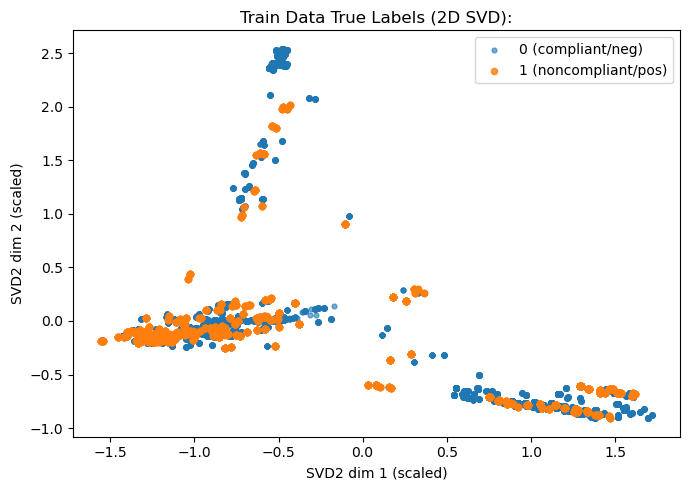

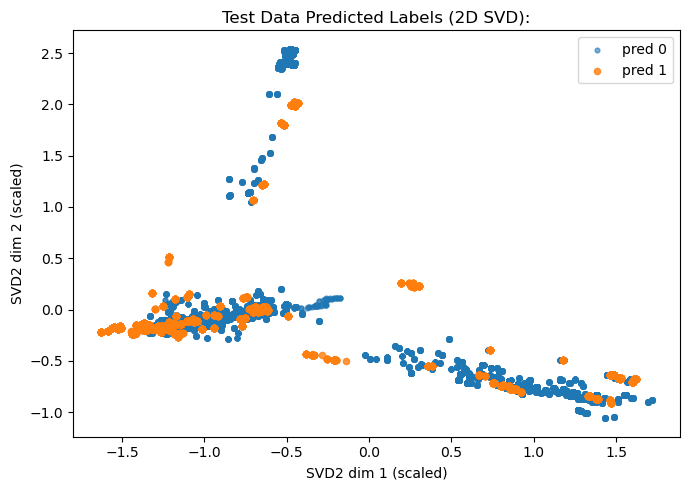

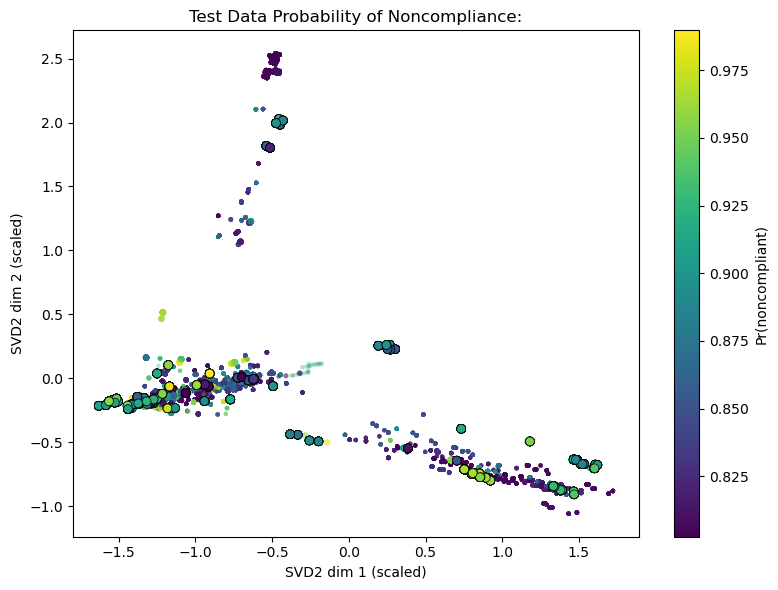

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Optional, Iterable, Dict, Tuple
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest
from openpyxl import Workbook, load_workbook
from openpyxl.styles import PatternFill
from sklearn.svm import OneClassSVM
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
from math import log
import pandas as pd
import numpy as np
import warnings
import pickle
import glob
import os
import re
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

# https://docs.python.org/3/library/dataclasses.html
''' class ConfigBlock:
decorator for fields defined by class variables
    "block_type": strings extracted while parsing the config to delineate/group sub-lines of config sections, 
        like "interface" configs, think of it as a section identifier that groups all interface blocks
    "header": string for a "root" unindented-line of indented-sublines from a config, like "interface GigabitEthernet1/0/1"
    "lines": list of strings containing all lines from that block including the header
'''
@dataclass
class ConfigBlock:
    block_type: str
    header: str
    lines: List[str]
    def text(self) -> str:
        return '\n'.join(self.lines)

''' def NormalizeHashes()
Regex substitution to replace hashed passwords, secrets; keys:
    hashed strings are dense and subject to large variations between configurations.
    Which ironically, the variations are greater when using cryptographically secure functions like:
    `secret` which returns a type 9 hash, or `password encryption aes` globally, or `hmac-sha2-256` on keys.
    These hashed output variations penalize scoring of secure configurations because -
    using a reversable hash like type 7 results in the same or extremely similar hashed strings on all device's config.

So, by normalizing any hashed string, it allows the classifier during training time to learn features 
representing the actual configured algorithm - like noncompliant `sha1` or `md5` vs compliant algorithms.
'''
def NormalizeHashes(line: str) -> str:
    s = line.rstrip('\r\n')
    s = re.sub(r'^(ntp authentication-key\s+\d+\s+\S+)\s+.*$', r'\1 <HASH>', s, flags=re.IGNORECASE)
    s = re.sub(r'^(username\s.*(?:secret|password)\s+\d+\s+).+$', r'\1<HASH>', s, flags=re.IGNORECASE)
    s = re.sub(r'^(enable\s+(?:secret|password)\s+\d+\s+).+$', r'\1<HASH>', s, flags=re.IGNORECASE)
    s = re.sub(r'^(.*(server-key)\s+).+$', r'\1<HASH>', s, flags=re.IGNORECASE)
    s = re.sub(r'^(key\s\d{1})\s.+$', r'\1<HASH>', s, flags=re.IGNORECASE)    
    s = re.sub(r'\s+', ' ', s).strip()
    return s

'''def NormalizeSSH()
The config section for defining allowed SSH client & server algorithms is subject to a ton of variability.
For example, in: "ip ssh server algorithm encryption aes256-gcm aes128-gcm aes256-ctr aes192-ctr aes128-ctr 3des-cbc" -
    the algorithms can appear in any order, combination, and combination of orders.

This makes it difficult to train a classifier to reliably detect the presence of a string like `3des-cbc`.
Now apply this same problem to 8 lines of SSH server & client algorithm configs in total.
After ordering the algorithms at train & test, the true-positive rate went up and the false-positive rate went down.
'''
def NormalizeSSH(line: str) -> str:
    s = re.sub(r'\s+', ' ', line.strip())
    low = s.lower()
    m = re.match(r'^(ip ssh (server|client) algorithm (\S+)) (.+)$', low)
    if not m:
        return s
    prefix = m.group(1)
    rest = m.group(4)
    algos = rest.split()
    algos_sorted = ' '.join(sorted(algos))
    return prefix + ' ' + algos_sorted

''' def FlagWeakSSH()
To further improve the classifiers ability to consistently identify noncompliant SSH client/server configuration lines,
FlagWeakSSH() examines each line of ssh algorithm against the WeakSSH set.
Each line like "ip ssh server algorithm encryption aes256-gcm aes128-gcm aes256-ctr aes192-ctr aes128-ctr 3des-cbc"
    is broken to its parts and those parts are tagged based on the regex match groups. The line above becomes:
        platform  = server
        field     = encryption
        remainder = aes256-gcm aes128-gcm aes256-ctr aes192-ctr aes128-ctr 3des-cbc
If a weak algorithm is found, OFFENDER_{algorithm} is appended to the tag list which looks like this:
    ["SSH_PLATFORM_server", "SSH_FIELD_encryption", "OFFENDER_3des-cbc"]
'''
WeakSSH = {'hmac-sha1','3des-cbc','diffie-hellman-group14-sha1','ssh-rsa','x509v3-ssh-rsa'}
def FlagWeakSSH(line: str) -> str:
    s = re.sub(r'\s+', ' ', line.strip())
    low = s.lower()
    m = re.match(r'^ip ssh (server|client) algorithm (\S+) (.+)$', low)
    if not m:
        return s
    platform, field, remainder = m.group(1), m.group(2), m.group(3)
    algos = remainder.split()
    tags = [
        f'SSH_PLATFORM_{platform}',
        f'SSH_FIELD_{field}',
    ]
    for a in algos:
        if a in WeakSSH:
            tags.append(f'OFFENDER_{a}')
    return s + ' ' + ' '.join(tags)

'''def LoadTrainData()
Loads a single csv dataset for UNSUPERVISED training of: OCSVM, LOF, AE.
The file contains 100 pseudo-random baseline "compliant" switch configs.
Each unique running-config is delineated by -
    the naturally occurring "end" which marks the last line of any IOS XE running-config.
'''
def LoadTrainData(path: str, line_col: str = 'line', end_token: str = 'end'):
    df = pd.read_csv(path)
    assert line_col in df.columns, f'Expected column "{line_col}" in {path}'
    compliant_configs = []
    current = []
    for raw in df[line_col].astype(str).tolist():
        line = raw.rstrip('\r\n')
        if line.strip() == '':
            continue
        current.append(line)
        if line.strip().lower() == end_token:
            compliant_configs.append(current)
            current = []
    if current:
        compliant_configs.append(current)
    return compliant_configs

'''def ExtractBlockHeader()
Regex "match" or "startswith" method extracts specific headers for grouping sublines; otherwise categorizing lines with:
    specific functionality/pertinence beyond simply "GLOBAL"
This enables more granular detection of misconfigurations in these blocks of features; -v.s.-
    learning that a compliant ntp key is "hmac-sha2-256" with all the other train/test noise in the global config.
This proved to be an effective and expedient solution to improve results in unsupervised learning while,
    avoiding determinism or jumping to labeled & supervised training.
'''
def ExtractBlockHeader(line: str) -> Optional[str]:
    line = line.strip()
    if re.match(r'^(ip http|no ip http)', line):
        return 'http'
    if re.match(r'^interface Vlan', line):
        return 'interface Vlan'
    if re.match(r'^interface [^V]', line):
        return 'interface'
    if re.match(r'^snmp-server [^e]', line):
        return 'snmp-server'
    if line.startswith('line con'):
        return 'line con'
    if line.startswith('ip ssh source'):
        return 'ip ssh source'
    if line.startswith('ip ssh client '):
        return 'ip ssh client'
    if line.startswith('ip ssh server '):
        return 'ip ssh server'
    if line.startswith('line vty'):
        return 'line vty'
    if line.startswith('spann'):
        return 'spanning-tree'
    if line.startswith('login'):
        return 'login'
    if line.startswith('vtp'):
        return 'vtp'
    if line.startswith('ntp'):
        return 'ntp'
    if line.startswith('enable'):
        return 'enable'
    if line.startswith('username'):
        return 'username'
    if line.startswith('version'):
        return 'version'
    if re.match(r'logging', line):
        return 'logging'
    if re.match(r'aaa group', line):
        return 'aaa group'
    if re.match(r'aaa authen', line):
        return 'aaa authentication'
    if re.match(r'aaa authori', line):
        return 'aaa authorization'
    if re.match(r'aaa accou', line):
        return 'aaa accounting'
    if re.match(r'aaa common', line):
        return 'aaa common-criteria'
    if re.match(r'aaa server', line):
        return 'aaa server'
    if re.match(r'^vlan\s+\S+', line):
        return 'vlan'
    if line.startswith('ip access-list standard '):
        return 'ip access-list standard'
    if line.startswith('ip access-list extended '):
        return 'ip access-list extended'        
    if line.startswith('tacacs server '):
        return 'tacacs server'
    if line.startswith('radius server '):
        return 'radius server'
    if line.startswith('ip default'):
        return 'ip default'
    if re.match(r'service', line):
        return 'service'
    if line.startswith('class-map '):
        return 'class-map'
    if line.startswith('policy-map '):
        return 'policy-map'
    if line.startswith('netconf-yang'):
        return 'netconf-yang'
    if line.startswith('call-home'):
        return 'call-home'
    return None

'''ExtractConfigBlocks()
Create blocks of configuration lines based on the indentation and on the header

So, lines within an interface configuration is blocked as
    "block_type" = "interface"
    "header" = "interface GigabitEthernet1/0/1"
    "lines" = all subsequent, indented lines
The block header is discovered through the "ExtractBlockHeader" function above. 

If a line does not match, ExtractBlockHeader returns None, and subsequently - 
    "ExtractConfigBlocks" sets the "block_type" and "header" as global.
'''
def ExtractConfigBlocks(ConfigLines: Iterable[str]) -> List[ConfigBlock]:
    blocks: List[ConfigBlock] = []
    CurrentBlock: Optional[ConfigBlock] = None
    global_lines: List[str] = []
    for raw_line in ConfigLines:
        line = raw_line.rstrip('\n\r')
        stripped = line.strip()
        if stripped == '' or stripped == '!' or stripped.lower() == 'end':
            continue
        indent = len(line) - len(line.lstrip())
        if indent == 0:
            block_type = ExtractBlockHeader(stripped)
            if block_type is not None:
                if CurrentBlock is not None:
                    blocks.append(CurrentBlock)
                    CurrentBlock = None
                CurrentBlock = ConfigBlock(block_type=block_type,header=stripped,lines=[stripped])
            else:
                if CurrentBlock is not None:
                    blocks.append(CurrentBlock)
                    CurrentBlock = None
                global_lines.append(stripped)
        else:
            if CurrentBlock is not None:
                CurrentBlock.lines.append(stripped)
            else:
                global_lines.append(stripped)
    if CurrentBlock is not None:
        blocks.append(CurrentBlock)
    if global_lines:
        blocks.append(ConfigBlock(
            block_type='global',
            header='GLOBAL-CONFIG',
            lines=['GLOBAL-CONFIG'] + global_lines))
    return blocks

'''LoadTestData()
opens each CSV test-set-config file, blocks & sanitizes the lines, converts doc to DataFrame of the those line rows
'''
def LoadTestData(test_dir: str, pattern: str = '*.csv', line_col: str = 'line') -> pd.DataFrame:
    rows = []
    files = sorted(glob.glob(os.path.join(test_dir, pattern)))
    if not files:
        return pd.DataFrame(columns=[
            '__hostname','__source_file','__block_idx','block_type','header','block_text','lines_list'])
    for f in files:
        base = os.path.basename(f)
        hostname = os.path.splitext(base)[0]
        df1 = pd.read_csv(f)
        if line_col not in df1.columns:
            raise ValueError(f'{f} missing required column "{line_col}"')
        test_lines = []
        for raw in df1[line_col].astype(str).tolist():
            ln = raw.rstrip('\r\n')
            if ln.strip() == '':
                continue
            test_lines.append(ln)
        blocks = ExtractConfigBlocks(test_lines)
        for bi, b in enumerate(blocks):
            rows.append({'__hostname': hostname,'__source_file': base,'__block_idx': bi,'block_type': b.block_type,
                         'header': b.header,'block_text': BlockToDoc(b),'lines_list': b.lines,})
    return pd.DataFrame(rows)

'''BlockToDoc()
Normalizes lines within a block, and creates a document of blocks distinguished by "BLOCKTYPE_" and deliniated by \n
'''
def BlockToDoc(block: ConfigBlock) -> str:
    out = []
    for ln in block.lines:
        ln2 = NormalizeHashes(ln)
        ln2 = NormalizeSSH(ln2)
        ln2 = FlagWeakSSH(ln2)
        out.append(ln2)
    return f'BLOCKTYPE_{block.block_type}\n' + '\n'.join(out)

'''SupervisedNormalization()
Really similar to "BlockToDoc" but called in "FeatureText" and "BlocksToLinesDF"
'''
def SupervisedNormalization(line: str) -> str:
    s = str(line).rstrip('\r\n')
    s = NormalizeHashes(s)
    s = NormalizeSSH(s)
    s = FlagWeakSSH(s)
    return s    

def FeatureText(scope: str, parent: str, line: str) -> str:
    scope = (scope or 'UNKNOWN').strip()
    parent = (parent or 'GLOBAL').strip()
    line_n = SupervisedNormalization(line)
    parent_tok = parent.lower()
    parent_tok = re.sub(r'[^a-z0-9]+', '_', parent_tok).strip('_')
    return f"SCOPE_{scope} PARENT_{parent_tok} {line_n}"    

'''BlocksToLinesDF()
This function is for supervised classification test time with the imbalanced learn model.
Because imbalanced learn was trained (fit) on the labeled training data that has "scope", "parent", "lines" in its shape - 
the unlabled test datasets lines need to be reshaped based on the "class ConfigBlock" fields:
    "scope" inherits "block_type"
    "parent" inherits "header"
    "lines" inherit "lines_list"
This is doubly necessary because the goal is to provide LINE LEVEL detection in the supervised model,
    in unsupervised, we detected and reported on BLOCK LEVELs because line level isn't possible in the first place.
But, I want to avoid the file-ops of re-reading all test-set config CSVs and building another DataFrame, etc..
    So, this function reuses the "TestData_BlocksDF" from unsupervised learning - 
    converts the DF from BLOCK to LINE with necessary lables to give each line the correct feature shape for imbalanced learn.
'''
def BlocksToLinesDF(TestData_BlocksDF: pd.DataFrame) -> pd.DataFrame:
    rows = []
    required = ["__hostname", "block_type", "header", "lines_list"]
    for c in required:
        if c not in TestData_BlocksDF.columns:
            raise ValueError(f"TestData_BlocksDF missing column: {c}")
    for _, r in TestData_BlocksDF.iterrows():
        hostname = r["__hostname"]
        scope = str(r["block_type"])
        parent = str(r["header"])
        lines = r["lines_list"]
        #if lines_list is nan or string, norm it
        if lines is None or (isinstance(lines, float) and np.isnan(lines)):
            continue
        #if stored as a string of a list
        if isinstance(lines, str):
            #treat as single line rather than character sequence
            lines = [lines]
        if not isinstance(lines, (list, tuple)):
            lines = [str(lines)]
        for ln in lines:
            #strip and normalize lines 
            s = SupervisedNormalization(ln)
            if s == "" or s == "!" or s.lower() == "end":
                continue
            rows.append({
                "__hostname": hostname,
                "scope": scope,
                "parent": parent,
                "line": s,
            })
    out = pd.DataFrame(rows)
    return out
    
''' def ResultWriter()
set "FlaggedOnly" = "True" to write out only configuration lines that were classified as noncompliant
set "topN" = an integer as upper bound for number of lines by decending score to write out
will make the directory from "OutDir", then joins the os.path with the filename that is "Results_{hostname}.xlsx"
writes that hostname's results to xlsx, opens the xlsx file; examines each rows flag columns for log, ocsvm; ae:
    if a row has no -1 flag set in any model's flag column, then the row remains un-filled
    if a row has a -1 flag set in AE or LOF flag column, then the row is filled orange
    if a row has a -1 flag set in AE+LOF or (AE+OCSVM|LOF+OCSVM) flag columns, then the row is filled red
    if a row has a -1 flag set in all three model's flag columns, then the row is filled purple
'''
def ResultWriter(ScoredBlocksDF: pd.DataFrame, dfSuperBlocks: pd.DataFrame, OutDir: str, FlaggedOnly: bool = False, topN: Optional[int] = None):
    os.makedirs(OutDir, exist_ok=True)
    #pregroup supervised results by hostname
    super_by_host = {h: g.copy() for h, g in dfSuperBlocks.groupby('__hostname', sort=True)}
    for hostname, d1 in ScoredBlocksDF.groupby('__hostname', sort=True):
        d1 = d1.sort_values(['__block_idx'])
        if FlaggedOnly and 'any_flag' in d1.columns:
            d1 = d1[d1['any_flag'] == 1]
        if topN is not None and 'max_score' in d1.columns:
            top = d1.sort_values('max_score', ascending=False).head(topN)
            d1 = top.sort_values('__block_idx')
        #supervised df for this same hostname
        d2 = super_by_host.get(hostname, pd.DataFrame())
        WriteDF1 = d1.drop(columns=['lines_list'], errors='ignore')
        WriteDF2 = d2
        OutPath = os.path.join(OutDir, f'Results_{hostname}.xlsx')
        #one write; two sheets
        with pd.ExcelWriter(OutPath, engine='openpyxl') as writer:
            WriteDF1.to_excel(writer, sheet_name='LOF-OCSVM-AE', index=False)
            WriteDF2.to_excel(writer, sheet_name='Imbalance-Learn', index=False)
        #openpyxl format fill color on unsupervised res
        wb = load_workbook(OutPath)
        ws = wb['LOF-OCSVM-AE'] #name the worksheet for unsupervised model results
        OrangeFill = PatternFill(start_color='F79646', end_color='F79646', fill_type='solid')
        RedFill    = PatternFill(start_color='FF5050', end_color='FF5050', fill_type='solid')
        PurpleFill = PatternFill(start_color='9966FF', end_color='9966FF', fill_type='solid')
        header_row = 1
        headers = {cell.value: idx + 1 for idx, cell in enumerate(ws[header_row])}
        lof_col   = headers.get('lof_flag')
        ocsvm_col = headers.get('ocsvm_flag')
        ae_col    = headers.get('ae_flags') or headers.get('ae_flag')
        if lof_col and ocsvm_col and ae_col:
            for row_idx in range(2, ws.max_row + 1):
                lof_flag   = ws.cell(row=row_idx, column=lof_col).value
                ocsvm_flag = ws.cell(row=row_idx, column=ocsvm_col).value
                ae_flag    = ws.cell(row=row_idx, column=ae_col).value
                
                #OCSVM is the most prone to false-positives, w/out unique strengths/results in true-positives,
                #so I hastily "weighted" results in the color-coding:
                if lof_flag == -1 and ocsvm_flag == -1 and ae_flag == -1:
                    fill = PurpleFill
                elif (lof_flag == -1 and ocsvm_flag == -1) or (ocsvm_flag == -1 and ae_flag == -1) or (lof_flag == -1 and ae_flag == -1):
                    fill = RedFill
                elif lof_flag == -1 or ae_flag == -1:
                    fill = OrangeFill
                else:
                    continue
                for col_idx in range(1, ws.max_column + 1):
                    ws.cell(row=row_idx, column=col_idx).fill = fill
        wb.save(OutPath)
        wb.close()

SVD_DIM = 100
svd = TruncatedSVD(n_components=SVD_DIM, random_state=42)
scaler = StandardScaler()

#--- TRAINING DATA ---
'''
Load into TrainDocs: <-- blocked <-- normalized <-- 
'''
CompliantConfigs_TrainData = LoadTrainData('CompliantSwitchDataSet.csv', line_col='line', end_token='end')
TrainBlocks: List[ConfigBlock] = []
for ConfigLines in CompliantConfigs_TrainData:
    blocks = ExtractConfigBlocks(ConfigLines)
    TrainBlocks.extend(blocks)
TrainDocs = [BlockToDoc(b) for b in TrainBlocks]

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
''' Term Frequency Inverse-Document Frequency:
Convert text to vectors; calc TF of terms in each block of "TrainDocs"; calcu IDF across all blocks--> X_BlocksTrain
`token_pattern` to match any word char, forward slash or hyphen and, extracts uni/bigrams; with default min_df of 1
'''
BlockVectorize = TfidfVectorizer(token_pattern=r'[\w/-]+',ngram_range=(1, 2),min_df=1)
X_BlocksTrain = BlockVectorize.fit_transform(TrainDocs)

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
''' Singular Value Decomposition "svd":
Calls scikit-learn TruncatedSVD with n_components=100 and random_state=42
Linear dimensionality reduction, efficient on sparse matrices; such as tf-idf for latent semantic analysis (LSA).
n_components sets output data dimensionality; 100 is the recommended value for LSA.
'''
X_DenseTrain = svd.fit_transform(X_BlocksTrain)

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
''' StandardScalar:
Center & scale independently on each feature by calc on each sample in train set; mean/std-dev used later in .transform
Important in SVM where features are assumed to center around 0 with variance in the same order.
'''
X_DenseTrain = scaler.fit_transform(X_DenseTrain)

#--- TEST DATA ---
'''
Load into DataFrame (TestData_BlocksDF): <-- blocked <-- normalized <-- config lines <-- Test Datasets config CSVs
Used at test time for unsupervised (LOF, OCSVM; AE) and supervised (Imbalance Learn) with modifcations addressed later.
These are the real world switch configs you would run the tool on. A mix of compliant and noncompliant lines in each confg.
'''
TestData_ConfigDir = r'C:\Users\PhilipMcDowell\00.01_PurdueLocal\573\Project\TestConfigs'
#TEST DATA: extraction --> blocks --> DataFrame --> 
TestData_BlocksDF = LoadTestData(TestData_ConfigDir, line_col='line')
# docs --> tfIDF --> SVD --> StdScaler 
TestDocs = TestData_BlocksDF['block_text'].tolist()
X_BlocksTestSet = BlockVectorize.transform(TestDocs) #vectorize blocks from test doc
X_DenseTest  = svd.transform(X_BlocksTestSet) #RECALL: svd = TruncatedSVD(n_components=SVD_DIM, random_state=42)
X_DenseTest  = scaler.transform(X_DenseTest) #RECALL: scaler = StandardScaler()

BlocksTestSet = [ConfigBlock(block_type=row['block_type'], header=row['header'], lines=row['lines_list'])for _, row in TestData_BlocksDF.iterrows()]

#--- UNSUPERVISED ---

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
# https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
''' Local Outlier Factor: 
Unsupervised novelty detection; computes local density deviation of data point wrt its neighbors.
Should set "n_neighbors" > min # samples a cluster may contain & < max # of close samples that could be local outliers.
Or said another way: 
"n_neighbors=20 appears to work well in general"; it is the actual number of neighbors used for kneighbor queries.

Critically, "novelty" default setting is False because LOF is meant to be used for outlier detection.SortedResultsOCSVM
to use LOF for novelty; set "=True" -- and only use `predict`, `decision_function` and `score_samples` on new unseen data
'''
lof = LocalOutlierFactor(n_neighbors=35, novelty=True, metric='euclidean')
lof.fit(X_DenseTrain)
lofDecision = lof.decision_function(X_DenseTest)
NoveltyScoresLOF = -lofDecision
lof_flag = lof.predict(X_DenseTest)
lofResultsBlock = list(zip(BlocksTestSet, NoveltyScoresLOF, lof_flag))
lofSortedResultsBlock = sorted(lofResultsBlock, key=lambda x: x[1], reverse=True)

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html
# https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
''' One Class SVM (OCSVM): 
Support Vector Machines would traditionally be used in supervised learning with labeled datasets allowing multiple classes.
But, as the name implies, One Class SVM is designed to perform novlety detection of datasets with one class, unsupervised.
It creates a learned "frontier" based on the high-dimensional distibution of training data.
New, test data that falls beyond that distribution frontier is novel.
'''
ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm.fit(X_BlocksTrain)
DecisionScores = ocsvm.decision_function(X_BlocksTestSet)
ocsvmNoveltyScores = -DecisionScores
ocsvmFlags = ocsvm.predict(X_BlocksTestSet)
ocsvm_block_results = list(zip(BlocksTestSet, ocsvmNoveltyScores, ocsvmFlags))
ocsvm_block_results_sorted = sorted(ocsvm_block_results, key=lambda x: x[1], reverse=True)

# https://blog.keras.io/building-autoencoders-in-keras.html
''' reconstruction Autoencoder:
AE is an effective comparison against OCSVM and LOF as a "self-supervised" model, 
    without building some fully connected Large Language Neural Network monster.
    
High-level: AE's take input, encode the input to a compressed form,
then decode the compressed input to a reconstructed version of the original input.

Oversimplified, if an AE accurately reconstructs input test data,
then it has been trained on that (or mathematically very similar) data...
    So, if an AE absolutely bombs reconstruction of test data, then that input is data the AE was not trained on.

This is where the Mean Squared Error comes in!
We train AE on the vector-space of the text data from varied compliant configs.
When it encodes, decodes, reconstructs test data: the reconstructed input with a low MSE is likely compliant;
    and, reconstructed input with a high MSE is novel (and in our case, likely noncompliant).

Chunking the configs into associated blocks and normalizing the lines in the blocks is *highly beneficial* to AE.
'''
AE_SVD_DIM = 400
AE_H1 = 128
AE_BOTTLENECK = 64
AE_LR = 1e-3
AE_EPOCHS = 40
AE_BATCH = 128
AE_VAL_SPLIT = 0.10
AE_SEED = 42
AE_THRESH_Q = 0.98
def _set_seeds(seed: int = AE_SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
def svdScaleFitTransform(X_sparse, svd_dim: int) -> Tuple[TruncatedSVD, StandardScaler, np.ndarray]:
    max_dim = max(2, min(svd_dim, X_sparse.shape[0] - 1, X_sparse.shape[1] - 1))
    svd = TruncatedSVD(n_components=max_dim, random_state=AE_SEED)
    X_dense = svd.fit_transform(X_sparse)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_dense)
    return svd, scaler, X_scaled
def svdScaleTransform(X_sparse, svd: TruncatedSVD, scaler: StandardScaler) -> np.ndarray:
    X_dense = svd.transform(X_sparse)
    X_scaled = scaler.transform(X_dense)
    return X_scaled

def BuildAE(input_dim: int, h1: int = AE_H1, bottleneck: int = AE_BOTTLENECK) -> keras.Model:
    model = keras.Sequential([layers.Input(shape=(input_dim,)),layers.Dense(h1, activation='relu'),
        layers.Dense(bottleneck, activation='relu'),layers.Dense(h1, activation='relu'),layers.Dense(input_dim, activation='linear')])
    model.compile(optimizer=keras.optimizers.Adam(AE_LR), loss='mse')
    return model
def ReconstructionMSE(x_true: np.ndarray, x_pred: np.ndarray) -> np.ndarray:
    return np.mean((x_true - x_pred) ** 2, axis=1)

@dataclass
class PipeAE:
    svd: TruncatedSVD
    scaler: StandardScaler
    ae: keras.Model
    threshold: float

def FitAE(X_train_blocks,svd_dim: int = AE_SVD_DIM,thresh_q: float = AE_THRESH_Q) -> PipeAE:
    _set_seeds(AE_SEED)
    svd, scaler, X_train = svdScaleFitTransform(X_train_blocks, svd_dim=svd_dim)
    ae = BuildAE(input_dim=X_train.shape[1], h1=AE_H1, bottleneck=AE_BOTTLENECK)
    ae.fit(X_train, X_train,epochs=AE_EPOCHS,batch_size=AE_BATCH,validation_split=AE_VAL_SPLIT,shuffle=True,verbose=0)
    X_train_recon = ae.predict(X_train, verbose=0)
    train_err = ReconstructionMSE(X_train, X_train_recon)
    T = float(np.quantile(train_err, thresh_q))
    return PipeAE(svd=svd, scaler=scaler, ae=ae, threshold=T)
def ScorePipe(pipe: PipeAE, X_test_sparse) -> Tuple[np.ndarray, np.ndarray]:
    X_test = svdScaleTransform(X_test_sparse, pipe.svd, pipe.scaler)
    X_recon = pipe.ae.predict(X_test, verbose=0)
    err = ReconstructionMSE(X_test, X_recon)
    flag = np.where(err >= pipe.threshold, -1, 1)
    return err, flag

ae_pipe = FitAE(X_BlocksTrain, svd_dim=AE_SVD_DIM, thresh_q=AE_THRESH_Q)

ae_scores, ae_flags = ScorePipe(ae_pipe, X_BlocksTestSet)

BlockResultsAE = list(zip(BlocksTestSet, ae_scores, ae_flags))

ScoredBlocksDF = TestData_BlocksDF.copy()
ScoredBlocksDF['lof_score'] = NoveltyScoresLOF.astype(float)
ScoredBlocksDF['lof_flag']  = lof_flag.astype(int)
ScoredBlocksDF['ocsvm_score'] = ocsvmNoveltyScores.astype(float)
ScoredBlocksDF['ocsvm_flag']  = ocsvmFlags.astype(int)
ScoredBlocksDF['ae_scores'] = ae_scores.astype(float)
ScoredBlocksDF['ae_flags']  = ae_flags.astype(int)
ScoredBlocksDF['any_flag'] = (
    (ScoredBlocksDF['lof_flag'] == -1) | (ScoredBlocksDF['ocsvm_flag'] == -1) | (ScoredBlocksDF['ae_flags'] == -1)).astype(int)

ScoredBlocksDF['max_score'] = ScoredBlocksDF[['lof_score', 'ocsvm_score', 'ae_scores']].max(axis=1)

#--- SUPERVISED ---

# https://imbalanced-learn.org/stable/user_guide.html#user-guide
''' imbalanced learn:
IMB learn is a method to address the problem of training/testing in data where the ratio of classes are highly imbalanced.
For example, switch configurations where, there's typically many more compliant lines than noncompliant lines.
This imbalance can impact the classifiers ability to learn class differences and identify different classes at test time.

For this implementation of IMB learn, the labeled training dataset must have the following columns:
    "config_id", "label", "scope", "parent", "line"
'''
IGNORE_LABEL_2 = True
SCOPE_FILTER = None
RANDOM_SEED = 42
TrainDF = pd.read_csv('LabeledSwitchDataSet.csv')

if SCOPE_FILTER is not None:
    TrainDF = TrainDF[TrainDF['scope'].astype(str).str.lower() == SCOPE_FILTER.lower()].copy()

#convert label
TrainDF['label'] = pd.to_numeric(TrainDF['label'], errors='coerce')
#drop irrelevant label 2
if IGNORE_LABEL_2:
    TrainDF = TrainDF[TrainDF['label'].isin([0, 1])].copy()
#binary target
y = TrainDF['label'].astype(int).values
#feature text
X_Text = [FeatureText(scope, parent, line) for scope, parent, line in zip(TrainDF['scope'], TrainDF['parent'], TrainDF['line'])]

groups = TrainDF['config_id'].astype(str).values  # so train/val doesn't leak within same config

#per config_id train/validation split to prevent leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_SEED)
TrainIDX, ValIDX = next(gss.split(X_Text, y, groups=groups))

X_TrainText = [X_Text[i] for i in TrainIDX]
y_Train = y[TrainIDX]

X_ValText = [X_Text[i] for i in ValIDX]
y_Val = y[ValIDX]

print('Train rows:', len(X_TrainText), ' Val rows:', len(X_ValText))
print('Train positives:', int(np.sum(y_Train == 1)), ' / ', len(y_Train))

#char_wb ngrams: robust to small changes, or ordering; quirks, etc
vec = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), min_df=1)

#oversample minority class, label=1, to reduce bias
ros = RandomOverSampler(random_state=RANDOM_SEED)

#LR on sparse TF-IDF
clf = LogisticRegression(max_iter=3000, solver='liblinear')

imb = ImbPipeline(steps=[('vec', vec), ('ros', ros), ('clf', clf)])
imb.fit(X_TrainText, y_Train)

#eval held-out configs val split
ValPr = imb.predict_proba(X_ValText)[:, 1]
ValPred = (ValPr >= 0.5).astype(int)

print('Validation report (threshold=0.5)')
print(classification_report(y_Val, ValPred, digits=4))
print('Confusion matrix:\n', confusion_matrix(y_Val, ValPred))
try:
    print('ROC AUC:', roc_auc_score(y_Val, ValPr))
    print('PR AUC :', average_precision_score(y_Val, ValPr))
except Exception as e:
    print('AUC computation skipped:', e)

TestDF = BlocksToLinesDF(TestData_BlocksDF)
X_TestText = [FeatureText(scope, parent, line) for scope, parent, line in zip(TestDF['scope'], TestDF['parent'], TestDF['line'])]

TestPr = imb.predict_proba(X_TestText)[:, 1]
TestPred = (TestPr >= 0.5).astype(int)

TestDF['pred_label'] = TestPred
TestDF['prob_noncompliant'] = TestPr

SupervisedResultsDF = TestDF.copy()

SortedSupervisedResultsDF = SupervisedResultsDF.sort_values('prob_noncompliant', ascending=False)

ResultsDir = r'C:\Users\PhilipMcDowell\00.01_PurdueLocal\573\Project\Results'
ResultWriter(ScoredBlocksDF, SortedSupervisedResultsDF, ResultsDir, FlaggedOnly=False, topN=None)

'''
Visualize supervised learning from Imbalanced Learn training and testing
'''
COL_SCOPE  = 'scope'
COL_PARENT = 'parent'
COL_LINE   = 'line'
COL_Y      = 'label'              #train truth = (0/1 or 0/1/2)
COL_P      = 'prob_noncompliant'  #test pred pr class 1
COL_YHAT   = 'pred_label'         #test pred label = (0/1)

#text feature builder like from training
def FeatureText(scope: str, parent: str, line: str) -> str:
    scope = str(scope) if scope is not None else ''
    parent = str(parent) if parent is not None else ''
    line = str(line) if line is not None else ''
    return f'SCOPE_{scope} PARENT_{parent} LINE_{line}'

def X_TextBuild(df: pd.DataFrame) -> list[str]:
    return [FeatureText(s, p, l) for s, p, l in zip(df[COL_SCOPE], df[COL_PARENT], df[COL_LINE])]

#lazily extract vectorizer from imb pipe
def TextVectFromIMB(pipe):
    if hasattr(pipe, 'named_steps'):
        for key in ['tfidf', 'vec', 'vectorizer', 'tfidfvectorizer']:
            if key in pipe.named_steps:
                return pipe.named_steps[key]
    raise ValueError('Could not find TF-IDF/vectorizer step in imb.named_steps')

#fit 2D projection on TRAIN TF-IDF; then project train and test
def TrainTest2D(imb, TrainDF: pd.DataFrame, TestDF: pd.DataFrame):
    vec = TextVectFromIMB(imb)
    X_TrainText = X_TextBuild(TrainDF)
    X_TestText  = X_TextBuild(TestDF)
    Xtr = vec.transform(X_TrainText)
    Xte = vec.transform(X_TestText)
    svd2 = TruncatedSVD(n_components=2, random_state=42)
    Xtr_2 = svd2.fit_transform(Xtr)
    Xte_2 = svd2.transform(Xte)
    Xtr_2 = scaler.fit_transform(Xtr_2)
    Xte_2 = scaler.transform(Xte_2)
    return Xtr_2, Xte_2

#plot 1- scatter train data by TRUE label
def PlotTrainTrue(X2, y, title='Train Data True Labels (2D SVD):'):
    plt.figure(figsize=(7, 5))
    y = np.asarray(y)
    m0 = (y == 0)
    m1 = (y == 1)
    plt.scatter(X2[m0, 0], X2[m0, 1], s=12, alpha=0.6, label='0 (compliant/neg)')
    plt.scatter(X2[m1, 0], X2[m1, 1], s=20, alpha=0.8, label='1 (noncompliant/pos)')
    plt.title(title)
    plt.xlabel('SVD2 dim 1 (scaled)')
    plt.ylabel('SVD2 dim 2 (scaled)')
    plt.legend()
    plt.tight_layout()
    plt.show()

#plot 2- scatter test data by PRED label
def PlotTestPred(X2, yhat, title='Test Data Predicted Labels (2D SVD):'):
    plt.figure(figsize=(7, 5))
    yhat = np.asarray(yhat)
    m0 = (yhat == 0)
    m1 = (yhat == 1)
    plt.scatter(X2[m0, 0], X2[m0, 1], s=12, alpha=0.6, label='pred 0')
    plt.scatter(X2[m1, 0], X2[m1, 1], s=20, alpha=0.8, label='pred 1')
    plt.title(title)
    plt.xlabel('SVD2 dim 1 (scaled)')
    plt.ylabel('SVD2 dim 2 (scaled)')
    plt.legend()
    plt.tight_layout()
    plt.show()

#plot 3- scatter test data color-coded by probability
def PlotTestPr(X2, probs, title='Test Data Probability of Noncompliance:'):
    plt.figure(figsize=(8, 6))
    bands = [
        (0.00, 0.40, 10, 0.20, 1),
        (0.40, 0.60, 14, 0.35, 2),
        (0.60, 0.80, 22, 0.60, 3),
        (0.80, 1.01, 40, 1.00, 10),
    ]
    for lo, hi, size, alpha, z in bands:
        mask = (probs >= lo) & (probs < hi)
        if not np.any(mask):
            continue
        plt.scatter(X2[mask, 0],X2[mask, 1],c=probs[mask],cmap='viridis',s=size,
            alpha=alpha,edgecolors='black' if lo >= 0.8 else 'none',
            linewidths=0.5 if lo >= 0.8 else 0,zorder=z)
    cbar = plt.colorbar()
    cbar.set_label('Pr(noncompliant)')
    plt.title(title)
    plt.xlabel('Scaled SVD2 dim 1')
    plt.ylabel('Scaled SVD2 dim 2')
    plt.tight_layout()
    plt.show()

train_y = (pd.to_numeric(TrainDF[COL_Y], errors='coerce').fillna(0).astype(int) == 1).astype(int).values
Xtr_2, Xte_2 = TrainTest2D(imb, TrainDF, TestDF)
PlotTrainTrue(Xtr_2, train_y)
PlotTestPred(Xte_2, TestDF[COL_YHAT].values)
PlotTestPr(Xte_2, TestDF[COL_P].values)
